In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [96]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('axes', linewidth = 3.)

load data

In [10]:
n_rois = 68
count_offset = 100
data_path = '../sample_data/'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path+'hcp_data.npy')
n_subs = brain_networks.shape[0]

In [4]:
std_trans = min_max_standardize(avg_trans)
std_rotat = min_max_standardize(avg_rotat)
motion = np.concatenate([std_trans, std_rotat], axis=-1)

In [5]:
with open(data_path+'hcp_traits_dict.txt') as f:
    lines = f.readlines()
f.close()

In [6]:
pic_vocab = traits[:,6]
card_sort = traits[:,42]
oral_reading = traits[:,4]
pattern_complete = traits[:,10]
pic_seq = traits[:,37]

In [47]:
# drop_ids = np.isnan(card_sort)
# card_sort = card_sort[~drop_ids]
# brain_networks = brain_networks[~drop_ids]
# motion = motion[~drop_ids]
# n_subs = brain_networks.shape[0]

In [48]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = .01, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=200, lr=1e-5, device=DEVICE)

In [49]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [50]:
ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(card_sort).to(torch.float32) 

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

956 107


vae

In [51]:
card_sort_vae = VAE(config).to(config.device)
card_sort_vae.apply(reset_weights)
card_sort_vae.set_mask(knn_masks)
optimizer = optim.Adam(card_sort_vae.parameters(), lr=config.lr) 

In [52]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = card_sort_vae.reg_train(epoch, train_loader, card_sort_vae, optimizer, config.device, n_epoch_display=5)
    val_loss = card_sort_vae.reg_test(epoch, val_loader, card_sort_vae, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 6928.883 nll: -1930.334 kl: 470.058 rmse: 16.643
epoch: 0 test loss: -866.011 nll: -8240.787 kl: 814.978 rmse: 16.326
epoch: 5 train loss: -16489.612 nll: -16888.158 kl: 15893.353 rmse: 2.729
epoch: 5 test loss: -16334.095 nll: -16659.417 kl: 15743.135 rmse: 2.443
epoch: 10 train loss: -16550.697 nll: -16939.666 kl: 15544.795 rmse: 2.694
epoch: 10 test loss: -16384.426 nll: -16703.218 kl: 15172.698 rmse: 2.437
epoch: 15 train loss: -16572.142 nll: -16952.323 kl: 15158.784 rmse: 2.665
epoch: 15 test loss: -16403.130 nll: -16715.207 kl: 14821.630 rmse: 2.413
epoch: 20 train loss: -16585.610 nll: -16956.942 kl: 14859.115 rmse: 2.631
epoch: 20 test loss: -16414.058 nll: -16719.833 kl: 14559.334 rmse: 2.386
epoch: 25 train loss: -16596.852 nll: -16959.225 kl: 14627.048 rmse: 2.591
epoch: 25 test loss: -16422.220 nll: -16721.963 kl: 14364.058 rmse: 2.355
epoch: 30 train loss: -16607.779 nll: -16960.808 kl: 14435.996 rmse: 2.546
epoch: 30 test loss: -16429.451 nll: -16723

inv_vae

In [56]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0., 
    beta = .01, gamma = .01, add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=200, lr=2e-5, device=DEVICE)

In [61]:
card_sort_inv = INV_VAE(config).to(config.device)
card_sort_inv.apply(reset_weights)
card_sort_inv.set_mask(knn_masks)
optimizer = optim.Adam(card_sort_inv.parameters(), lr=config.lr) 

In [62]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = card_sort_inv.reg_train(epoch, train_loader, card_sort_inv, optimizer, config.device, n_epoch_display=5)
    val_loss = card_sort_inv.reg_test(epoch, val_loader, card_sort_inv, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 7790.565 nll: -7341.400 kl: 1021.744 inv_loss: 12.106 rmse: 15.610
epoch: 0 test loss 4850.109 nll: -15230.920 kl: 2991.546 inv_loss: 32.985 rmse: 13.455
epoch: 5 train loss: 62.541 nll: -16932.855 kl: 22014.324 inv_loss: 2.435 rmse: 2.683
epoch: 5 test loss -5.935 nll: -16697.262 kl: 21266.108 inv_loss: 2.014 rmse: 2.387
epoch: 10 train loss: 52.571 nll: -16947.582 kl: 26584.306 inv_loss: 1.949 rmse: 2.625
epoch: 10 test loss -12.191 nll: -16704.438 kl: 23951.607 inv_loss: 1.650 rmse: 2.340
epoch: 15 train loss: 40.048 nll: -16952.681 kl: 24047.374 inv_loss: 1.865 rmse: 2.551
epoch: 15 test loss -19.465 nll: -16710.011 kl: 23008.283 inv_loss: 1.679 rmse: 2.283
epoch: 20 train loss: 26.465 nll: -16959.583 kl: 28828.886 inv_loss: 1.798 rmse: 2.467
epoch: 20 test loss -26.935 nll: -16715.171 kl: 25196.833 inv_loss: 1.504 rmse: 2.224
epoch: 25 train loss: 12.911 nll: -16965.258 kl: 31243.941 inv_loss: 1.787 rmse: 2.380
epoch: 25 test loss -33.327 nll: -16719.926 kl: 2

plotting

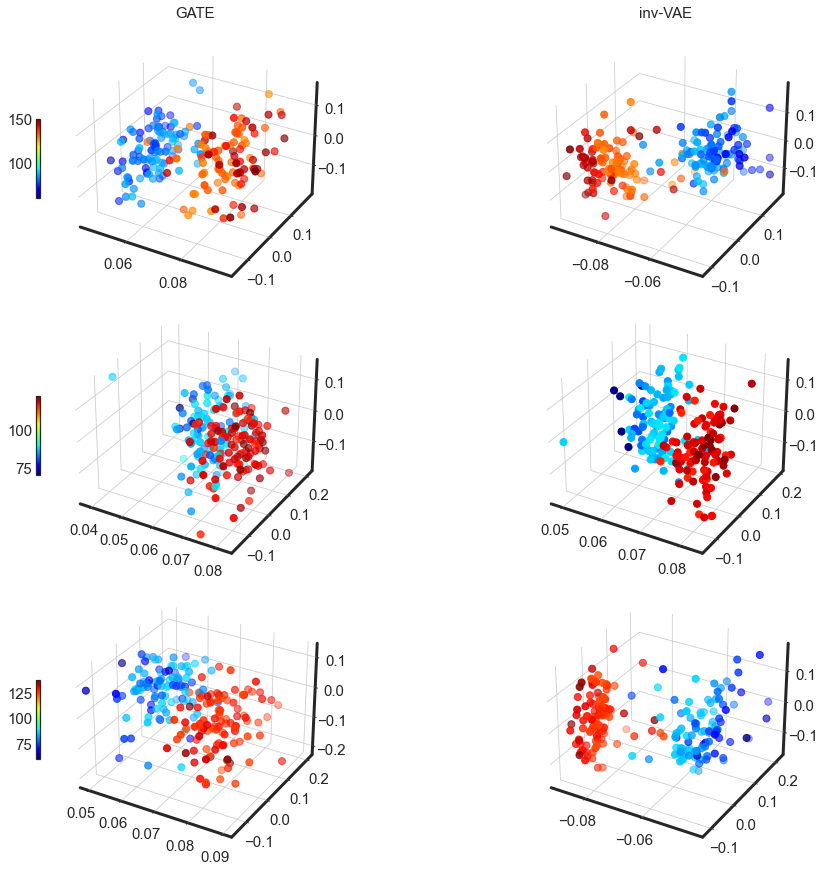

In [97]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True, subplot_kw=dict(projection='3d'))
plt.style.use('seaborn-white')

################## pic vocab - vae ##################
pic_vocab_vae_z_mean, _ = pic_vocab_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, pic_vocab_vae_y_pred, _, _ = pic_vocab_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
pic_vocab_vae_y_pred = pic_vocab_vae_y_pred.detach().cpu().numpy()

pic_vocab_y_ids = np.argsort(pic_vocab)
pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

pic_vocab_vae_z_mean_sub = pic_vocab_vae_z_mean[pic_vocab_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(pic_vocab_vae_z_mean_sub.transpose())
pic_vocab_vae_pcs = pca.components_.transpose()

p1 = axes[0,0].scatter(pic_vocab_vae_pcs[:,0], pic_vocab_vae_pcs[:,1], pic_vocab_vae_pcs[:,2], c=pic_vocab_vae_colors, cmap = 'jet', s = 50, vmin=60, vmax=150)
cb = fig.colorbar(p1, ax=axes[0,0], location='left', fraction=0.01)
axes[0,0].set_title('GATE')
axes[0,0].set_xlim3d(min(pic_vocab_vae_pcs[:,0]), max(pic_vocab_vae_pcs[:,0]))
axes[0,0].set_ylim3d(min(pic_vocab_vae_pcs[:,1]), max(pic_vocab_vae_pcs[:,1]))
axes[0,0].set_zlim3d(min(pic_vocab_vae_pcs[:,2]), max(pic_vocab_vae_pcs[:,2]))

################## pic vocab - inv_vae ##################
pic_vocab_inv_z_mean, _ = pic_vocab_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, pic_vocab_inv_y_pred, _, _ = pic_vocab_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                                             tensor_motion.to(config.device))
pic_vocab_inv_y_pred = pic_vocab_inv_y_pred.detach().cpu().numpy()

pic_vocab_y_ids = np.argsort(pic_vocab)
pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

pic_vocab_inv_z_mean_sub = pic_vocab_inv_z_mean[pic_vocab_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(pic_vocab_inv_z_mean_sub.transpose())
pic_vocab_inv_pcs = pca.components_.transpose()

p2 = axes[0,1].scatter(pic_vocab_inv_pcs[:,0], pic_vocab_inv_pcs[:,1], pic_vocab_inv_pcs[:,2], c=pic_vocab_vae_colors, cmap = 'jet', s = 50, vmin=60, vmax=150)
axes[0,1].set_title('inv-VAE')
axes[0,1].set_xlim3d(min(pic_vocab_inv_pcs[:,0]), max(pic_vocab_inv_pcs[:,0]))
axes[0,1].set_ylim3d(min(pic_vocab_inv_pcs[:,1]), max(pic_vocab_inv_pcs[:,1]))
axes[0,1].set_zlim3d(min(pic_vocab_inv_pcs[:,2]), max(pic_vocab_inv_pcs[:,2]))


################## card sort - vae ##################
card_sort_vae_z_mean, _ = card_sort_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, card_sort_vae_y_pred, _, _ = card_sort_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
card_sort_vae_y_pred = card_sort_vae_y_pred.detach().cpu().numpy()

card_sort_y_ids = np.argsort(card_sort)
card_sort_y_sub_ids = np.concatenate([card_sort_y_ids[:100], card_sort_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
card_sort_vae_colors = card_sort[card_sort_y_sub_ids]

card_sort_vae_z_mean_sub = card_sort_vae_z_mean[card_sort_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(card_sort_vae_z_mean_sub.transpose())
card_sort_vae_pcs = pca.components_.transpose()

p3 = axes[1,0].scatter(card_sort_vae_pcs[:,0], card_sort_vae_pcs[:,1], card_sort_vae_pcs[:,2], 
                       c=card_sort_vae_colors, cmap = 'jet', s = 50, vmin=70)
cb = fig.colorbar(p3, ax=axes[1,0], location='left', fraction=0.01)
axes[1,0].set_xlim3d(min(card_sort_vae_pcs[:,0]), max(card_sort_vae_pcs[:,0]))
axes[1,0].set_ylim3d(min(card_sort_vae_pcs[:,1]), max(card_sort_vae_pcs[:,1]))
axes[1,0].set_zlim3d(min(card_sort_vae_pcs[:,2]), max(card_sort_vae_pcs[:,2]))


################## card sort - inv_vae ##################
card_sort_inv_z_mean, _ = card_sort_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, card_sort_inv_y_pred, _, _ = card_sort_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                                             tensor_motion.to(config.device))
card_sort_inv_y_pred = card_sort_inv_y_pred.detach().cpu().numpy()

card_sort_y_ids = np.argsort(card_sort)
card_sort_y_sub_ids = np.concatenate([card_sort_y_ids[:100], card_sort_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
card_sort_vae_colors = card_sort[card_sort_y_sub_ids]

card_sort_inv_z_mean_sub = card_sort_inv_z_mean[card_sort_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(card_sort_inv_z_mean_sub.transpose())
card_sort_inv_pcs = pca.components_.transpose()

p4 = axes[1,1].scatter(card_sort_inv_pcs[:,0], card_sort_inv_pcs[:,1], card_sort_inv_pcs[:,2], c=card_sort_vae_colors, 
                       cmap = 'jet', s = 50, alpha=1., vmin=70)
axes[1,1].set_xlim3d(min(card_sort_inv_pcs[:,0]), max(card_sort_inv_pcs[:,0]))
axes[1,1].set_ylim3d(min(card_sort_inv_pcs[:,1]), max(card_sort_inv_pcs[:,1]))
axes[1,1].set_zlim3d(min(card_sort_inv_pcs[:,2]), max(card_sort_inv_pcs[:,2]))


################## oral reading - vae ##################
oral_reading_vae_z_mean, _ = oral_reading_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, oral_reading_vae_y_pred, _, _ = oral_reading_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
oral_reading_vae_y_pred = oral_reading_vae_y_pred.detach().cpu().numpy()

oral_reading_y_ids = np.argsort(oral_reading)
oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

oral_reading_vae_z_mean_sub = oral_reading_vae_z_mean[oral_reading_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(oral_reading_vae_z_mean_sub.transpose())
oral_reading_vae_pcs = pca.components_.transpose()

p5 = axes[2,0].scatter(oral_reading_vae_pcs[:,0], oral_reading_vae_pcs[:,1], oral_reading_vae_pcs[:,2], c=oral_reading_vae_colors, cmap = 'jet', s = 50)
plt.colorbar(p5, ax=axes[2,0], location='left', fraction=0.01)
axes[2,0].set_xlim3d(min(oral_reading_vae_pcs[:,0]), max(oral_reading_vae_pcs[:,0]))
axes[2,0].set_ylim3d(min(oral_reading_vae_pcs[:,1]), max(oral_reading_vae_pcs[:,1]))
axes[2,0].set_zlim3d(min(oral_reading_vae_pcs[:,2]), max(oral_reading_vae_pcs[:,2]))


################## oral reading - inv_vae ##################
oral_reading_inv_z_mean, _ = oral_reading_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, oral_reading_inv_y_pred, _, _ = oral_reading_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                                             tensor_motion.to(config.device))
oral_reading_inv_y_pred = oral_reading_inv_y_pred.detach().cpu().numpy()

oral_reading_y_ids = np.argsort(oral_reading)
oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

oral_reading_inv_z_mean_sub = oral_reading_inv_z_mean[oral_reading_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(oral_reading_inv_z_mean_sub.transpose())
oral_reading_inv_pcs = pca.components_.transpose()

p6 = axes[2,1].scatter(oral_reading_inv_pcs[:,0], oral_reading_inv_pcs[:,1], oral_reading_inv_pcs[:,2], c=oral_reading_vae_colors, cmap = 'jet', s = 50)
axes[2,1].set_xlim3d(min(oral_reading_inv_pcs[:,0]), max(oral_reading_inv_pcs[:,0]))
axes[2,1].set_ylim3d(min(oral_reading_inv_pcs[:,1]), max(oral_reading_inv_pcs[:,1]))
axes[2,1].set_zlim3d(min(oral_reading_inv_pcs[:,2]), max(oral_reading_inv_pcs[:,2]))

for i in range(3):
    for j in range(2):
        axes[i,j].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        axes[i,j].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        axes[i,j].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# plt.savefig('saved_figs/fig8_hcp_trait_latents.png', facecolor='white', dpi=800)
plt.show()